In [ ]:
! nvidia-smi

Wed May 12 18:47:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

# Seq2seq

In [ ]:
%matplotlib inline

В этом проекте мы будем учиться делать перевод с французского на английский. Примерно так:

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

Для этого мы будем исплользовать мощную идею «sequence-to-sequence» сетей (https://arxiv.org/abs/1409.3215), в которых две рекуррентные сети обучаются вместе для преоразования одной последовательности в другую.

* Encoder-сеть сжимает входную последовательность в вектор.
* Decoder-сеть разжимает этот вектор в новую последовательность.

Всё как с автоэнкодерами, только encoder и decoder из разных доменов.

Чтобы вся эта схема обучалась стабильнее, мы будем использовать механизм attention (https://arxiv.org/abs/1409.0473), позволяющий декодеру «фокусироваться» на специфичных токенах входной последовательности.

**Рекомендуемое чтение:**

-  Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation (https://arxiv.org/abs/1406.1078)
-  Sequence to Sequence Learning with Neural
   Networks (https://arxiv.org/abs/1409.3215)
-  Neural Machine Translation by Jointly Learning to Align and
   Translate 9https://arxiv.org/abs/1409.0473)
-  A Neural Conversational Model (https://arxiv.org/abs/1506.05869>)

Если кто-то пропустил предыдущие занатия, то лучше сначала сделать их: основные концепции такие же, как в языковых моделях.

In [ ]:
# осторожно: тетрадка старая

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Данные

В этом проекте мы будем работать с кучей пар предложений на английском и французском.

Скачайте данные отсюда (https://download.pytorch.org/tutorial/data.zip) и возьмите оттуда файлик eng-fra.txt. В нём должно быть много строчек примерно такого формата:

    I am cold.    J'ai froid.

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip

--2021-05-12 18:47:31--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.33.56, 99.86.33.87, 99.86.33.64, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.33.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.04s   

2021-05-12 18:47:31 (67.9 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [ ]:
!wc -l data/eng-fra.txt

135842 data/eng-fra.txt


In [ ]:
! head data/eng-fra.txt

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


Делать предобработку будем по аналогии с char-level RNN-ками из предыдущих туториалов, только на этот раз нам важно отдельно запариться с EOS (end-of-sequence) — специальным токеном, который сеть будет генерировать при окончании генерации предложения.

In [ ]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
    def __repr__(self):
        most_popular_words = sorted(
            self.word2count.keys(), key=lambda word: self.word2count[word], reverse=True
        )[:10]
        most_popular_words = ", ".join(most_popular_words)
        return f"Language: {self.name} | Num words: {self.n_words} | Most popular: {most_popular_words}"

Все файлы в юникоде. Чтобы  облегчить нам работу, мы переведем все в ASCII, сделаем lowercase и выкинем большинство пунктуации.

In [ ]:
# "hello!" -> hello, ! 

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

При чтении данных разделим файл на строки, а строки на пары.




In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Данных у нас **много**, но мы сейчас хотим обучить что-нибудь по-быстрому, поэтому оставим оттуда только короткие и простые предложения — с длиной до 10 слов (включая пунктуацию).

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Полный процесс такой:

- Считать текстовый файл, просплитить по линиям, а затем по парам.
- Нормализовать текст, профильтровать по длине.
- Сделать готовые списки слов из сырых предложений в каждом языке.

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis sidere .', 'i m stunned .']


In [ ]:
input_lang

Language: fra | Num words: 4345 | Most popular: ., je, suis, est, vous, pas, de, il, nous, tu

In [ ]:
output_lang

Language: eng | Num words: 2803 | Most popular: ., i, re, you, m, he, not, is, a, to

In [ ]:
len(pairs)

10599

In [ ]:
pairs[24]

['je vais bien .', 'i m fine .']

![Screenshot%202020-12-19%20at%2016.44.09.png](attachment:Screenshot%202020-12-19%20at%2016.44.09.png)The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.


Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




![Screenshot%202020-12-19%20at%2016.44.54.png](attachment:Screenshot%202020-12-19%20at%2016.44.54.png)The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.




In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        # num_embedding = vocab_size_fra
        self.embedder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # (batch_size, num_words) -> (batch_size, num_words, dim_1)
        embeddings = self.embedder(input).view(1, 1, -1)
        # (batch_size, num_words, dim_2)
        output, hidden = self.gru(embeddings, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
tokens = torch.randint(0, 1000, size=(128, 40))
embedder = nn.Embedding(1000, 128)  # здесь лежит матрица

In [ ]:
onehot = torch.nn.functional.one_hot(tokens, num_classes=1000)

In [ ]:
embeddingds_first_way = embedder(tokens)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




![Screenshot%202020-12-19%20at%2016.45.11.png](attachment:Screenshot%202020-12-19%20at%2016.45.11.png)Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).




In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedder = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # (batch_size, num_words, dim)
        # (1, 1, num_words * dim)
        output = self.embedder(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        # (batch_size, num_words, dim) -> (batch_size, num_words, num_classes)
        # (batch_size, num_words, vocab_size_eng)
        output = self.out(output[0])
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




![Screenshot%202020-12-19%20at%2016.45.28.png](attachment:Screenshot%202020-12-19%20at%2016.45.28.png)Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.




In [ ]:
# v^TWm
# U^T tanh (W_1 v + W_2 m)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(
                torch.cat((embedded[0], hidden[0]), 1)
            ), 
            dim=1
        )
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0),
            encoder_outputs.unsqueeze(0)
        )

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [ ]:
teacher_forcing_ratio = 0.5


def train(
    input_tensor, 
    target_tensor,
    encoder, 
    decoder, 
    encoder_optimizer,
    decoder_optimizer, 
    criterion,
    max_length=MAX_LENGTH
):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        # y_true: [sos, i, love, pizza, eos]
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # [0.9, 0.1, 0.0]
            # [1, 0, 0]
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # beam_search is betters
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                # y_true: [sos, i, eos]
                # [sos, i, eos, love]
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [ ]:
hidden_size = 256

encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=50)

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> j emploie un nouvel ordinateur .
= i am using a new computer .
< i m going to a a . <EOS>

> ce ne sont pas mes prisonniers .
= they re not my prisoners .
< i m not my my . <EOS>

> vous etes tres braves .
= you re very brave .
< you re very sophisticated . <EOS>

> je suis ici n est ce pas ?
= i m here aren t i ?
< i m here aren t you ? <EOS>

> je ne suis sure de rien .
= i m not sure of anything .
< i m afraid to see you . <EOS>

> tu ne saisis pas .
= you re missing the point .
< you re not a . <EOS>

> t es un drole de gars .
= you re a funny guy .
< you re a funny . <EOS>

> tu analyses trop .
= you re over analyzing .
< you re too . <EOS>

> tu es stupide de lui faire confiance .
= you re stupid to trust him .
< you re out of me . <EOS>

> c est l un de mes voisins .
= he is one of my neighbours .
< he is one of my . <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




In [ ]:
%matplotlib inline

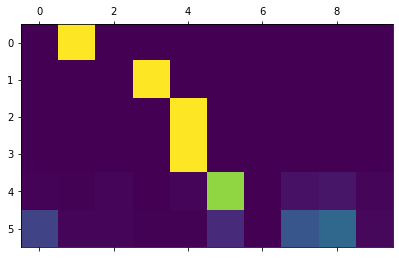

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())
plt.show()

For a better viewing experience we will do the extra work of adding axes
and labels:




input = elle a cinq ans de moins que moi .
output = she is two years than me . <EOS>


/mnt/chatbot_models2/fursov/tasks/ENV/virtualenvs/mlkit-32Y97wqZ-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/mnt/chatbot_models2/fursov/tasks/ENV/virtualenvs/mlkit-32Y97wqZ-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


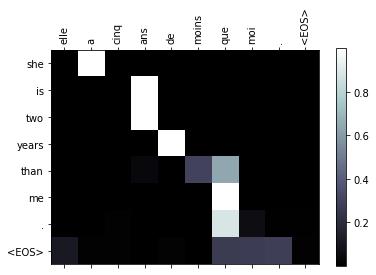

input = elle est trop petit .
output = she is too too . <EOS>


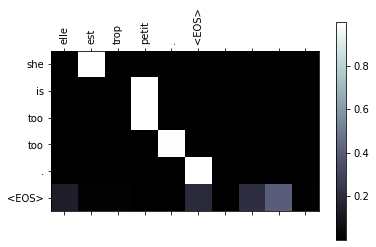

input = je ne crains pas de mourir .
output = i m not afraid to <EOS>


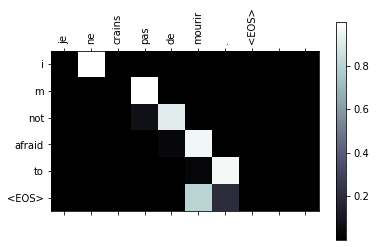

input = c est un jeune directeur plein de talent .
output = he is a man man . <EOS>


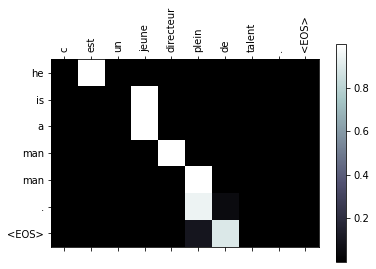

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

In [ ]:
data = [
    ("где поесть?", "здесь"),
    ("что сделать?", "ничего")
]

# что делать, если такого слова не видели
# @fursov

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there




# New Dataset == New Life

> Тяжело найти интересный датасет. Я нашёл датасет SQUAD_v2.0 (Текст, вопрос по тексту, ответ на вопрос), но я боюсь, что это слишком сложный датасет, так как надо именно в тексте искать ответы на вопрос. Есть ещё датасет нормализации русского текста (чиселки цифрами в чиселки текстами перевести с учётом форм слов по контексту). Наверное, попробую такой датасет. Он, скорее всего, может быть детерменированно по правилам языка может быть решён, но я попробую через seq2seq. А squad покопаю на досуге. 

In [ ]:
import pandas as pd
from tqdm import tqdm
import itertools
from google.colab import drive
drive.mount('/content/drive')


from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_table = pd.read_csv('/content/drive/MyDrive/ru_train.csv')

In [ ]:
data_table.head(20)

,sentence_id,token_id,class,before,after
0,0,0,PLAIN,По,По
1,0,1,PLAIN,состоянию,состоянию
2,0,2,PLAIN,на,на
3,0,3,DATE,1862 год,тысяча восемьсот шестьдесят второй год
4,0,4,PUNCT,.,.
5,1,0,PLAIN,Оснащались,Оснащались
6,1,1,PLAIN,латными,латными
7,1,2,PLAIN,рукавицами,рукавицами
8,1,3,PLAIN,и,и
9,1,4,PLAIN,сабатонами,сабатонами


> Пристально смотрим на наш датасет. Мы его сейчас немного изменим. Мы возьмём некоторый набор классов (*'class'* column) и в *X* они будут как в *'before'*, а в *target* как в *'after'*. Остальные классы мы оставим без изменений.
Какие классы мы изменим:



*   **DATE**: 17 июля 2014 -> семнадцатого июля две тысячи четырнадцатого года
*   **ORDINAL**: 7-й -> седьмой
*   **MEASURE**: 480 с. -> четыреста восемьдесят секунд
*   **CARDINAL**: 12 -> двенадцать

Всё остальное просто копируем из *before*. Ну и поделим всё по предложениям, конечно же.

In [ ]:
def build_sentences(dataset, att_classes):
    sents_before = []
    sents_after = []
    for i in tqdm(range(len(dataset))):
        if len(sents_before) <= dataset.loc[i, 'sentence_id']:
            sents_before.append(['<START>'])
            sents_after.append(['<START>'])
        cur_id = dataset.loc[i, 'sentence_id']
        if dataset.loc[i, 'class'] in att_classes:
            sents_before[cur_id].append(str(dataset.loc[i, 'before']))
            sents_after[cur_id].append(str(dataset.loc[i, 'after'].lower()))
        else:
            sents_before[cur_id].append(str(dataset.loc[i, 'before']).lower())
            sents_after[cur_id].append(str(dataset.loc[i, 'before']).lower())
    for i in range(len(sents_after)):
        sents_before[i].append('<END>')
        sents_after[i].append('<END>')
    return sents_before, sents_after

In [ ]:
dataset, target = build_sentences(data_table.loc[:1000000], ['DATE', 'ORDINAL', 'MEASURE', 'CARDINAL'])

100%|██████████| 1000001/1000001 [01:21<00:00, 12284.77it/s]


In [ ]:
(' '.join(dataset[22]), ' '.join(target[22]))

('<START> 7 октября 2010 года территория республики конго отошла к новоучрежденной браззавильской и габонской епархии . <END>',
 '<START> седьмого октября две тысячи десятого года территория республики конго отошла к новоучрежденной браззавильской и габонской епархии . <END>')

> В этой домашке батчей не будет (ну они будут размера 1). Надо написать класс Vocab. Наверное, он будет один общий для dataset и target, так как словари не сильно отличаются по факту.

In [ ]:
class Vocab:
    def __init__(self, data_X, data_y):
        dataset = data_X + data_y
        self.idx2word = list(set(itertools.chain(*dataset)))
        self.idx2word.append('<UNK>')
        self.word2idx = {}
        for i, word in tqdm(enumerate(self.idx2word)):
            self.word2idx[word] = i
        self.data_X = [self.tokenize(i) for i in tqdm(data_X)]
        self.data_y = [self.tokenize(i) for i in tqdm(data_y)]
    
    def tokenize(self, sequence):
        return [self.word2idx[i] for i in sequence]
    
    def detokenize(self, sequence):
        return [self.idx2word[i] for i in sequence]
    
    def __getitem__(self, key):
        return (self.data_X[key], self.data_y[key])
    
    def __len__(self):
        return len(self.data_X)

> Это больше класс датасета получился, чем класс словаря. Ну и ладно

In [ ]:
data = Vocab(dataset[:1050], target[:1050])

7342it [00:00, 1569950.55it/s]
100%|██████████| 1050/1050 [00:00<00:00, 244369.06it/s]


In [ ]:
len(data.idx2word)

7342

In [ ]:
data.detokenize(data[666][1])

['<START>',
 'мукополисахаридозы',
 'типов',
 'три',
 ',',
 'iv',
 ',',
 'vi',
 ',',
 'семь',
 '.',
 '<END>']

In [ ]:
data_ = pd.read_csv('/content/drive/MyDrive/ru_train.csv')

In [ ]:
data_[data_['sentence_id'] == 666]

,sentence_id,token_id,class,before,after
9045,666,0,PLAIN,Мукополисахаридозы,Мукополисахаридозы
9046,666,1,PLAIN,типов,типов
9047,666,2,CARDINAL,III,три
9048,666,3,PUNCT,",",","
9049,666,4,LETTERS,IV,i v
9050,666,5,PUNCT,",",","
9051,666,6,LETTERS,VI,v i
9052,666,7,PUNCT,",",","
9053,666,8,CARDINAL,VII,семь
9054,666,9,PUNCT,.,.


In [ ]:
set(data_[data_['before'] == 'IV']['class'])

{'LETTERS', 'ORDINAL'}

> Ну тут даже в исходном датасете не все римские числа были корректно типизированы. Это может сказаться на нашей нейронке. Ладно, продолжаем. Хотя, вроде IV -> 'четыре' нет. Там только порядковые как число определяются.

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.emb = torch.nn.Embedding(len(data.idx2word), embedding_dim)
        self.rnn = torch.nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, dropout=0.6)

    def forward(self, x, hidden):
        embedded = self.emb(x).view(-1, 1, self.embedding_dim) # (seq_len = -1, batch = 1, input_size = embeddin_dim)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

> Смотрим, как должен выглядить Decoder с Attention. Самый простой:

1.   $v_i = embedding(token_i)$
2.   $\alpha^T_i = v_i\cdot W\cdot output_E$
3.   $att_i = output_E\cdot softmax(\alpha_i)$
4.   $hidden_{D, i} = GRU(v_i, att_i, hidden_{D, i - 1})$
5.   $Probas_i = softmax(FC\cdot hidden_{D, i})$

Потом можем добавить ещё одну RNN для подсчёта v_i.

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.emb = torch.nn.Embedding(len(data.idx2word), embedding_dim)
        self.rnn = torch.nn.GRU(input_size=embedding_dim + hidden_size, hidden_size=hidden_size, dropout=0.6)
        self.W = torch.nn.Linear(embedding_dim, hidden_size)
        self.FC = torch.nn.Linear(hidden_size, len(data.idx2word))

    def forward(self, token, hidden, enc_out): # here goes only one token
        # token : (1, 1, 1)
        # hidden : (1, 1, hidden_size)
        # enc_out : (1, hidden_size, enc_input)
        embedded = self.emb(token).view(1, 1, self.embedding_dim) # v_i
        att_w = F.softmax(torch.transpose(torch.bmm(self.W(embedded), enc_out), 1, 2), dim=1) # (batch, enc_seq_out, 1)
        att = torch.bmm(enc_out, att_w).view(1, 1, -1) # (1, 1, hidden)
        x = torch.cat((att, embedded), dim=2) # (1, 1, hidden + embedding)
        output, hidden = self.rnn(F.silu(x), hidden)
        probas = self.FC(hidden)
        return probas, hidden, att_w
    

> теперь обучение....

In [ ]:
encoder = EncoderRNN(128, 128).to(device)
decoder = DecoderRNN(128, 128).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer_E = torch.optim.Adam(encoder.parameters(), lr=0.0004)
optimizer_D = torch.optim.Adam(decoder.parameters(), lr=0.0004)
EPOCHS = 50 # 60 epochs is +- enough
teacher_forcing_ratio = 0.6

> Я запустил обучение на всём датасете и внезапно понял, что он огромный. Очень. Ожидаемое время одной эпохи - 

In [ ]:
len(data.idx2word)

7342

In [ ]:
hist_losses = []
end_token_id = data.word2idx['<END>']
for epoch in range(EPOCHS):
    permutation = np.random.permutation(len(data))
    true_target = []
    predicted_target = []
    for j in range(len(data)):
        encoder.zero_grad()
        decoder.zero_grad()
        X, y = data[permutation[j]]

        # Take random prefix
        sz = len(X)
        r_bound = random.randint(max(2, sz // 2), sz - 1) + 1
        X = X[:r_bound] + [data.word2idx['<END>']]
        y = y[:r_bound] + [data.word2idx['<END>']]

        X = torch.tensor(X, device=device).view(1, -1)
        # y = torch.tensor(y, device=device).view(1, -1)
        hidden = encoder.initHidden()
        output_E, hidden = encoder(X, hidden)
        # output_E : seq x 1 x hidden_size <-- need reshape
        # hidden : 1 x 1 x hidden_size
        output_E = torch.swapaxes(output_E, 0, 1)
        output_E = torch.swapaxes(output_E, 1, 2)
        # output_E : 1 x hidden_size x seq
        loss = 0
        true_target.append('')
        predicted_target.append('')
        # print(len(y) - 1)
        
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        if use_teacher_forcing:
            for i in range(len(y) - 1):
                token = torch.tensor([y[i]], device=device)
                token = token.view(1, 1, 1)

                probas, hidden, att_w = decoder(token, hidden, output_E)
                # print(probas.view(1, -1).shape)
                loss += criterion(probas.view(1, -1), torch.tensor([y[i + 1]], device=device))
                true_target[-1] += ' ' + data.idx2word[y[i + 1]]
                idx_pred = torch.argmax(torch.squeeze(probas)).detach().cpu().item()
                predicted_target[-1] += ' ' + data.idx2word[idx_pred]
        else:
            token = torch.tensor([y[0]], device=device) 
            for i in range(len(y) - 1):
                token = token.to(device).view(1, 1, 1)

                probas, hidden, att_w = decoder(token, hidden, output_E)
                # print(probas.view(1, -1).shape)
                loss += criterion(probas.view(1, -1), torch.tensor([y[i + 1]], device=device))
                true_target[-1] += ' ' + data.idx2word[y[i + 1]]
                idx_pred = torch.argmax(torch.squeeze(probas)).detach().cpu().item()
                predicted_target[-1] += ' ' + data.idx2word[idx_pred]
                token = torch.tensor([idx_pred], device=device)
                if idx_pred == end_token_id:
                    break
        loss.backward()
        optimizer_D.step()
        optimizer_E.step()
        hist_losses.append(loss.detach().cpu().item() / (len(y) - 1))
        if (j % 210 == 0):
            print(j, np.mean(hist_losses[max(0, j - 42):-1]))
    print(f'Epoch {epoch} finished, loss : {hist_losses[-1]:.7f}')
    for i in range(1, 2):
        print(true_target[-i], predicted_target[-i])
    print('================')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 nan
210 6.180996584895361
420 6.169732103889494
630 6.590951806450275
840 5.787517022044737
Epoch 0 finished, loss : 3.4263179
 начальник цос фсб рф андрей ларюшин  в в , , . <END>
0 6.095761981802
210 6.129911499687391
420 6.097486532490127
630 6.071718017836658
840 6.037387165868788
Epoch 1 finished, loss : 3.9215999
 энциклопедия туризма кирилла и  проверено ( . <END>
0 6.067619482991958
210 6.045388059644612
420 6.036047439020831
630 5.990507836004399
840 5.930082722396339
Epoch 2 finished, loss : 4.3863440
 съемок ) « небо зовет  проверено « » » <END>
0 5.970414654227882
210 5.9411951807606345
420 5.926149331416791
630 5.877812552689321
840 5.834530932202376
Epoch 3 finished, loss : 5.9016044
 в четвертую неделю альбом покинул топ - десять , опустившись <END>  в конце , , , , , , , , ,
0 5.881423084228117
210 5.8534846097007
420 5.82308854381745
630 5.778858404049257
840 5.728103849541764
Epoch 4 finished, loss : 6.6900155
 альбом получил платиновый статус riaa и в целом положит

Пока оно обучается: небольшой отчёт.

Было тяжело. Поэтому я поставил много костылей.

> Изначально в датасете около 700k предложений. Ожидаемое время обучения было около 60-80 **часов** на эпоху. Поэтому я взял меньше предложений. Но оказалось, что там много различных слов и нейронка должна очень долго учиться, чтобы не ставить много точек везде. Поэтому я оставил всего 840 предложений ~ 6k различных токенов (слов).

> Далее из-за небольшого словаря он не смог распознать слово 'Эти'. Именно с большой буквы. Я уверен, что аналог с маленькой буквы есть в словаре. Поэтому я принял решение убрать заглавные буквы. Так станет чуть-чуть проще. Ну и после всех этих преобразований нейросеть неплохо обучается за 50 эпох (судя по тренировочной выборке)

In [ ]:
for X, y in data:
    print(data.detokenize(y))
    break

['<START>', 'по', 'состоянию', 'на', 'тысяча восемьсот шестьдесят второй год', '.', '<END>']


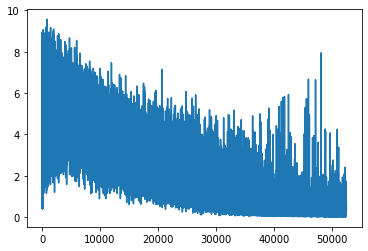

In [ ]:
plt.plot(hist_losses)

In [ ]:
def prepare_sent(sent):
    seq = []
    for word in sent:
        if word not in data.idx2word:
            word = '<UNK>'
        seq.append(data.word2idx[word])
    return seq

In [ ]:
def predict(seq):
    encoder.eval()
    decoder.eval()
    seq = prepare_sent(seq)
    predicted_target = ''
    att = []
    with torch.no_grad():
        X = seq
        X = torch.tensor(X, device=device).view(1, -1)
        # y = torch.tensor(y, device=device).view(1, -1)
        hidden = encoder.initHidden()
        output_E, hidden = encoder(X, hidden)
        # output_E : seq x 1 x hidden_size <-- need reshape
        # hidden : 1 x 1 x hidden_size
        output_E = torch.swapaxes(output_E, 0, 1)
        output_E = torch.swapaxes(output_E, 1, 2)
        # output_E : 1 x hidden_size x seq
        # true_target = ''
        # print(len(y) - 1)
        token = torch.tensor([data.word2idx['<START>']], device=device) 
        word_hidden = decoder.initHidden()
        for i in range(228):
            token = token.to(device).view(1, 1, 1)

            probas, hidden, att_w, word_hidden = decoder(token, hidden, output_E, word_hidden)
            att.append(torch.squeeze(att_w).detach().cpu().numpy())
            # print(probas.view(1, -1).shape)
            # loss += criterion(probas.view(1, -1), torch.tensor([y[i + 1]], device=device))
            # true_target[-1] += ' ' + data.idx2word[y[i + 1]]
            idx_pred = torch.argmax(torch.squeeze(probas)).detach().cpu().item()
            predicted_target += ' ' + data.idx2word[idx_pred]
            token = torch.tensor([idx_pred], device=device)
            if idx_pred == end_token_id:
                break
    encoder.train()
    decoder.train()
    return predicted_target, att

In [ ]:
id = 13
# id = 51842
print('Before : ', dataset[id])
print('True : ', target[id])
# predict(['<START>', 'в', 'конце', '1811 года', ',', 'вследствие', 'конфликта', '.', '<END>'])[0]
predict(dataset[id])[0]

Before :  ['<START>', 'революция', '1905 года', 'потерпела', 'поражение', '.', '<END>']
True :  ['<START>', 'революция', 'тысяча девятьсот пятого года', 'потерпела', 'поражение', '.', '<END>']


' революция тысяча девятьсот пятого года потерпела поражение . <END>'

In [ ]:
' '.join(dataset[2])

'<START> в конце 1811 года , вследствие конфликта с проезжим вельможей ( графом салтыковым ) вынужден был оставить службу по личному прошению . <END>'

 революция тысяча девятьсот пятого года потерпела поражение . <END>


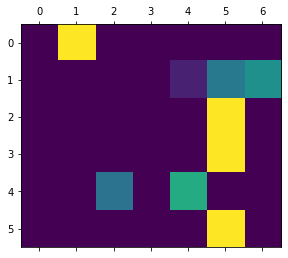

[array([2.7882480e-30, 1.0000000e+00, 8.3713606e-16, 6.0067743e-24,
        1.3879586e-32, 2.4232195e-31, 3.0217044e-35], dtype=float32),
 array([1.5706958e-12, 1.3345511e-08, 2.2581339e-08, 1.2065402e-07,
        9.1716915e-02, 4.0522394e-01, 5.0305903e-01], dtype=float32),
 array([5.8661309e-16, 1.7264250e-12, 1.8741617e-10, 3.1731736e-07,
        2.9038319e-03, 9.9709392e-01, 1.8499721e-06], dtype=float32),
 array([1.8713336e-05, 3.9400604e-13, 4.7568178e-06, 1.0001550e-07,
        1.8801174e-08, 9.9996591e-01, 1.0454131e-05], dtype=float32),
 array([8.6406942e-14, 3.0284224e-05, 3.8212600e-01, 3.0019996e-03,
        6.1467117e-01, 2.8283646e-05, 1.4222569e-04], dtype=float32),
 array([7.1777349e-18, 2.7088068e-25, 9.0359859e-20, 1.2729144e-17,
        1.8412320e-16, 1.0000000e+00, 8.4540601e-16], dtype=float32)]

In [ ]:
output_words, attentions = predict(dataset[13])#['<START>', 'проверено', 'в', 'конце', '1811 года', '.', '<END>'])
plt.matshow(attentions)
print(output_words)
plt.show()
attentions

> А вот Attention как-то не очень работает. Сейчас попробую улучшение: Я буду в decoder перед всем делать не просто embedding слова, а пропускать это слово через ещё одну GRU и как representation vector слова буду брать hidden из этой GRU. Он как-то эти все предложения запоминает, но даже префиксы тренировочного датасета плохо предсказывает.

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.emb = torch.nn.Embedding(len(data.idx2word), embedding_dim)
        self.word_rnn = torch.nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, dropout=0.6)
        self.rnn = torch.nn.GRU(input_size=embedding_dim + hidden_size, hidden_size=hidden_size, dropout=0.6)
        self.W = torch.nn.Linear(embedding_dim, hidden_size)
        self.drop = torch.nn.Dropout(0.6)
        self.FC = torch.nn.Linear(hidden_size, len(data.idx2word))

    def forward(self, token, hidden, enc_out, word_hidden): # here goes only one token
        # token : (1, 1, 1)
        # hidden : (1, 1, hidden_size)
        # enc_out : (1, hidden_size, enc_input)
        embedded = self.emb(token).view(1, 1, self.embedding_dim) # v_i
        out, word = self.word_rnn(embedded, word_hidden)
        att_w = F.softmax(torch.transpose(torch.bmm(self.drop(self.W(word)), enc_out), 1, 2), dim=1) # (batch, enc_seq_out, 1)
        att = torch.bmm(enc_out, att_w).view(1, 1, -1) # (1, 1, hidden)
        x = torch.cat((att, word), dim=2) # (1, 1, hidden + embedding)
        output, hidden = self.rnn(F.silu(x), hidden)
        probas = self.FC(hidden)
        return probas, hidden, att_w, word
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

In [ ]:
encoder = EncoderRNN(128, 128).to(device)
decoder = DecoderRNN(128, 128).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer_E = torch.optim.Adam(encoder.parameters(), lr=0.001)
optimizer_D = torch.optim.Adam(decoder.parameters(), lr=0.001)
EPOCHS = 50 # 60 epochs is +- enough
teacher_forcing_ratio = 0.4

In [ ]:
hist_losses = []
end_token_id = data.word2idx['<END>']
for epoch in range(EPOCHS):
    permutation = np.random.permutation(len(data))
    true_target = []
    predicted_target = []
    for j in range(len(data)):
        encoder.zero_grad()
        decoder.zero_grad()
        X, y = data[permutation[j]]

        # Take random segment
        sz = len(X)
        r_bound = random.randint(max(2, sz // 2), sz - 1) + 1
        l_bound = random.randint(1, r_bound - 1)
        X = [data.word2idx['<START>']] + X[l_bound:r_bound] + [data.word2idx['<END>']]
        y = [data.word2idx['<START>']] + y[l_bound:r_bound] + [data.word2idx['<END>']]


        X = torch.tensor(X, device=device).view(1, -1)
        # y = torch.tensor(y, device=device).view(1, -1)
        hidden = encoder.initHidden()
        output_E, hidden = encoder(X, hidden)
        # output_E : seq x 1 x hidden_size <-- need reshape
        # hidden : 1 x 1 x hidden_size
        output_E = torch.swapaxes(output_E, 0, 1)
        output_E = torch.swapaxes(output_E, 1, 2)
        # output_E : 1 x hidden_size x seq
        loss = 0
        true_target.append('')
        predicted_target.append('')
        # print(len(y) - 1)
        word_hidden = decoder.initHidden()
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        if use_teacher_forcing:
            for i in range(len(y) - 1):
                token = torch.tensor([y[i]], device=device)
                token = token.view(1, 1, 1)

                probas, hidden, att_w, word_hidden = decoder(token, hidden, output_E, word_hidden)
                # print(probas.view(1, -1).shape)
                loss += criterion(probas.view(1, -1), torch.tensor([y[i + 1]], device=device))
                true_target[-1] += ' ' + data.idx2word[y[i + 1]]
                idx_pred = torch.argmax(torch.squeeze(probas)).detach().cpu().item()
                predicted_target[-1] += ' ' + data.idx2word[idx_pred]
        else:
            token = torch.tensor([y[0]], device=device) 
            for i in range(len(y) - 1):
                token = token.to(device).view(1, 1, 1)

                probas, hidden, att_w, word_hidden = decoder(token, hidden, output_E, word_hidden)
                # print(probas.view(1, -1).shape)
                loss += criterion(probas.view(1, -1), torch.tensor([y[i + 1]], device=device))
                true_target[-1] += ' ' + data.idx2word[y[i + 1]]
                idx_pred = torch.argmax(torch.squeeze(probas)).detach().cpu().item()
                predicted_target[-1] += ' ' + data.idx2word[idx_pred]
                token = torch.tensor([idx_pred], device=device)
                if idx_pred == end_token_id:
                    break
        loss.backward()
        optimizer_D.step()
        optimizer_E.step()
        hist_losses.append(loss.detach().cpu().item() / (len(y) - 1))
        if (j % 210 == 0):
            print(j, np.mean(hist_losses[max(0, j - 42):-1]))
    print(f'Epoch {epoch} finished, loss : {hist_losses[-1]:.7f}')
    for i in range(1, 2):
        print(true_target[-i], predicted_target[-i])
    print('----------------')
    print(predict(['<START>', 'в', 'конце', '1811 года', ',', 'вследствие', 'конфликта', '.', '<END>'])[0])
    print('================')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 nan
210 1.1675334607106305
420 0.9328023842550844
630 1.2483834042247492
840 1.172076068900302
Epoch 0 finished, loss : 1.0251495
 административный центр поселения — хутор плотников <END>  хутор центр поселения — хутор плотников плотников
----------------
 в крулл , , , деревне . <END>
0 1.0951203452519038
210 1.1056973510795247
420 1.1056060674898092
630 1.1240375352497818
840 1.12682816830217
Epoch 1 finished, loss : 0.0198919
 сельского поселения . <END> <END>  сельского поселения . <END> <END>
----------------
 в мастерской , , . . . <END>
0 1.1094656159147782
210 1.1069080105047253
420 1.115188500882707
630 1.113210127883522
840 1.1025331366415418
Epoch 2 finished, loss : 0.9138207
 с запада , а одиннадцатая гвардейская атаковала <END>  с запада , а гвардейская гвардейская <END> <END>
----------------
 в конце мастерской , . . <END>
0 1.1064198114423631
210 1.1094144677038487
420 1.1100994109738076
630 1.1143981707129669
840 1.1060751241789397
Epoch 3 finished, loss : 0.1089230


In [ ]:
print(predict(['<START>', 'в', 'конце', '1811 года', ',', 'вследствие', 'конфликта', '.', '<END>'])[0])

 в конце . , , . <END>


 поражение тысяча девятьсот пятого года потерпела поражение . <END>


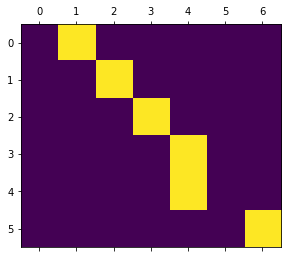

[array([0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0., 0., 1., 0., 0., 0., 0.], dtype=float32),
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        6.0674894e-36, 0.0000000e+00, 0.0000000e+00], dtype=float32),
 array([0.000000e+00, 0.000000e+00, 0.000000e+00, 3.624347e-37,
        1.000000e+00, 1.732397e-39, 3.174530e-40], dtype=float32),
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        9.9610537e-01, 7.6938467e-15, 3.8945857e-03], dtype=float32),
 array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.3143187e-22, 1.0000000e+00], dtype=float32)]

In [ ]:
output_words, attentions = predict(dataset[13])
plt.matshow(attentions)
print(output_words)
plt.show()
attentions

> Оооо, attentions начали работать корректно, ура.

In [ ]:
def predict(seq):
    encoder.eval()
    decoder.eval()
    seq = prepare_sent(seq)
    predicted_target = []
    att = []
    with torch.no_grad():
        X = seq
        X = torch.tensor(X, device=device).view(1, -1)
        # y = torch.tensor(y, device=device).view(1, -1)
        hidden = encoder.initHidden()
        output_E, hidden = encoder(X, hidden)
        # output_E : seq x 1 x hidden_size <-- need reshape
        # hidden : 1 x 1 x hidden_size
        output_E = torch.swapaxes(output_E, 0, 1)
        output_E = torch.swapaxes(output_E, 1, 2)
        # output_E : 1 x hidden_size x seq
        # true_target = ''
        # print(len(y) - 1)
        token = torch.tensor([data.word2idx['<START>']], device=device) 
        word_hidden = decoder.initHidden()
        for i in range(228):
            token = token.to(device).view(1, 1, 1)

            probas, hidden, att_w, word_hidden = decoder(token, hidden, output_E, word_hidden)
            att.append(torch.squeeze(att_w).detach().cpu().numpy())
            # print(probas.view(1, -1).shape)
            # loss += criterion(probas.view(1, -1), torch.tensor([y[i + 1]], device=device))
            # true_target[-1] += ' ' + data.idx2word[y[i + 1]]
            idx_pred = torch.argmax(torch.squeeze(probas)).detach().cpu().item()
            predicted_target += [data.idx2word[idx_pred]]
            token = torch.tensor([idx_pred], device=device)
            if idx_pred == end_token_id:
                break
    encoder.train()
    decoder.train()
    return predicted_target, att

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence, rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

['поражение', 'тысяча девятьсот пятого года', 'потерпела', 'поражение', '.', '<END>']


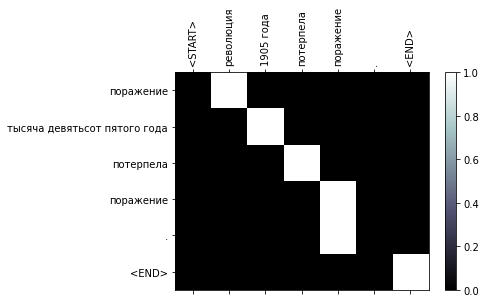

In [ ]:
output_words, attentions = predict(dataset[13])
print(output_words)
showAttention(dataset[13], output_words, attentions)

> С предобученным word2vec было бы лучше, наверное. Но на векторизацию тратится очень много времени. Из-за этого 1 эпоха обучения ~ 500 минут. Поэтому результата в ячейках ниже нет существенного. Ладно. Основная цель -- разобраться с seq2seq и Attention выполнена.

### Безуспешные попытки прикрутить pretrained word2vec

In [ ]:
!pip install simple-elmo

     |████████████████████████████████| 51kB 7.1MB/s 


In [ ]:
from simple_elmo import ElmoModel
emb_model = ElmoModel()
emb_model.load('/content/drive/MyDrive/195(elmo).zip')

2021-05-14 10:16:06,805 : INFO : Loading model from /content/drive/MyDrive/195(elmo).zip...
2021-05-14 10:16:06,808 : INFO : 
            Assuming the model is a ZIP archive downloaded from the NLPL vector repository.
            Loading a model from a ZIP archive directly is slower than from the extracted files,
            but does not require additional disk space
            and allows to load from directories without write permissions.
            
2021-05-14 10:16:06,830 : INFO : We will cache the vocabulary of 100 tokens.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py:903: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: 

'The model is now loaded.'

In [ ]:
emb_model.get_elmo_vector_average(['привет', 'кто', 'я', '<START>', '.']).shape

2021-05-14 10:18:42,839 : INFO : Warming up ELMo on 5 sentences...
2021-05-14 10:18:45,676 : INFO : Warming up finished.
2021-05-14 10:18:45,678 : INFO : Texts in the current batch: 5


(5, 1024)

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        # self.emb = torch.nn.Embedding(len(data.idx2word), embedding_dim)
        self.rnn = torch.nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, dropout=0.6)

    def forward(self, x, hidden):
        embedded = x.view(-1, 1, self.embedding_dim) # (seq_len = -1, batch = 1, input_size = embeddin_dim)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        # self.emb = torch.nn.Embedding(len(data.idx2word), embedding_dim)
        self.word_rnn = torch.nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, dropout=0.6)
        self.rnn = torch.nn.GRU(input_size=hidden_size + hidden_size, hidden_size=hidden_size, dropout=0.6)
        self.W = torch.nn.Linear(hidden_size, hidden_size)
        self.drop = torch.nn.Dropout(0.6)
        self.FC = torch.nn.Linear(hidden_size, len(data.idx2word))

    def forward(self, token, hidden, enc_out, word_hidden): # here goes only one token
        # token : (1, 1, 1)
        # hidden : (1, 1, hidden_size)
        # enc_out : (1, hidden_size, enc_input)
        embedded = token.view(1, 1, self.embedding_dim) # v_i
        out, word = self.word_rnn(embedded, word_hidden)
        att_w = F.softmax(torch.transpose(torch.bmm(self.drop(self.W(word)), enc_out), 1, 2), dim=1) # (batch, enc_seq_out, 1)
        att = torch.bmm(enc_out, att_w).view(1, 1, -1) # (1, 1, hidden)
        x = torch.cat((att, word), dim=2) # (1, 1, hidden + embedding)
        output, hidden = self.rnn(F.silu(x), hidden)
        probas = self.FC(hidden)
        return probas, hidden, att_w, word
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

In [ ]:
def predict(seq):
    encoder.eval()
    decoder.eval()
    seq = prepare_sent(seq)
    predicted_target = []
    att = []
    with torch.no_grad():
        X = seq
        X = emb_model.get_elmo_vector_average(data.detokenize(X))

        X = torch.FloatTensor(X).to(device) # seq_len x 1024
        
        # y = torch.tensor(y, device=device).view(1, -1)
        hidden = encoder.initHidden()
        output_E, hidden = encoder(X, hidden)
        # output_E : seq x 1 x hidden_size <-- need reshape
        # hidden : 1 x 1 x hidden_size
        output_E = torch.swapaxes(output_E, 0, 1)
        output_E = torch.swapaxes(output_E, 1, 2)
        # output_E : 1 x hidden_size x seq
        # true_target = ''
        # print(len(y) - 1)
        word_hidden = decoder.initHidden()
        token = torch.FloatTensor(emb_model.get_elmo_vector_average(['<START>'])).to(device)
        for i in range(228):
            token = token.view(1, 1, 1024)
            probas, hidden, att_w, word_hidden = decoder(token, hidden, output_E, word_hidden)
            att.append(torch.squeeze(att_w).detach().cpu().numpy())
            # print(probas.view(1, -1).shape)
            # loss += criterion(probas.view(1, -1), torch.tensor([y[i + 1]], device=device))
            # true_target[-1] += ' ' + data.idx2word[y[i + 1]]
            idx_pred = torch.argmax(torch.squeeze(probas)).detach().cpu().item()
            predicted_target += [data.idx2word[idx_pred]]
            
            token = torch.FloatTensor(emb_model.get_elmo_vector_average(data.detokenize([idx_pred]))).to(device)
            if idx_pred == end_token_id:
                break
    encoder.train()
    decoder.train()
    return predicted_target, att

In [ ]:
encoder = EncoderRNN(1024, 256).to(device)
decoder = DecoderRNN(1024, 256).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer_E = torch.optim.Adam(encoder.parameters(), lr=0.001)
optimizer_D = torch.optim.Adam(decoder.parameters(), lr=0.001)
EPOCHS = 1 # 60 epochs is +- enough
teacher_forcing_ratio = 0.5

In [ ]:
hist_losses = []
end_token_id = data.word2idx['<END>']
for epoch in range(EPOCHS):
    permutation = np.random.permutation(len(data))
    true_target = []
    predicted_target = []
    for j in range(len(data)):
        encoder.zero_grad()
        decoder.zero_grad()
        X, y = data[permutation[j]]

        # Take random segment
        sz = len(X)
        r_bound = random.randint(max(2, sz // 2), sz - 1) + 1
        l_bound = random.randint(1, r_bound - 1)
        X = [data.word2idx['<START>']] + X[l_bound:r_bound] + [data.word2idx['<END>']]
        y = [data.word2idx['<START>']] + y[l_bound:r_bound] + [data.word2idx['<END>']]
        
        X = emb_model.get_elmo_vector_average(data.detokenize(X), warmup=False)

        X = torch.FloatTensor(X).to(device) # seq_len x 1024
        # y = torch.tensor(y, device=device).view(1, -1)
        hidden = encoder.initHidden()
        output_E, hidden = encoder(X, hidden)
        # output_E : seq x 1 x hidden_size <-- need reshape
        # hidden : 1 x 1 x hidden_size
        output_E = torch.swapaxes(output_E, 0, 1)
        output_E = torch.swapaxes(output_E, 1, 2)
        # output_E : 1 x hidden_size x seq
        loss = 0
        true_target.append('')
        predicted_target.append('')
        # print(len(y) - 1)
        word_hidden = decoder.initHidden()
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        if use_teacher_forcing:
            for i in range(len(y) - 1):
                token = torch.FloatTensor(emb_model.get_elmo_vector_average(data.detokenize([y[i]]), warmup=False)).to(device)
                token = token.view(1, 1, 1024)

                probas, hidden, att_w, word_hidden = decoder(token, hidden, output_E, word_hidden)
                # print(probas.view(1, -1).shape)
                loss += criterion(probas.view(1, -1), torch.tensor([y[i + 1]], device=device))
                true_target[-1] += ' ' + data.idx2word[y[i + 1]]
                idx_pred = torch.argmax(torch.squeeze(probas)).detach().cpu().item()
                predicted_target[-1] += ' ' + data.idx2word[idx_pred]
        else:
            token = torch.FloatTensor(emb_model.get_elmo_vector_average(data.detokenize([y[0]]), warmup=False)).to(device)
            for i in range(len(y) - 1):
                token = torch.FloatTensor(emb_model.get_elmo_vector_average(data.detokenize([y[i]]), warmup=False)).to(device)
                token = token.view(1, 1, 1024)

                probas, hidden, att_w, word_hidden = decoder(token, hidden, output_E, word_hidden)
                # print(probas.view(1, -1).shape)
                loss += criterion(probas.view(1, -1), torch.tensor([y[i + 1]], device=device))
                true_target[-1] += ' ' + data.idx2word[y[i + 1]]
                idx_pred = torch.argmax(torch.squeeze(probas)).detach().cpu().item()
                predicted_target[-1] += ' ' + data.idx2word[idx_pred]
                token = torch.tensor([idx_pred], device=device)
                if idx_pred == end_token_id:
                    break
        loss.backward()
        optimizer_D.step()
        optimizer_E.step()
        hist_losses.append(loss.detach().cpu().item() / (len(y) - 1))
        if (j % 210 == 0):
            print(j, np.mean(hist_losses[max(0, j - 42):-1]))
    print(f'Epoch {epoch} finished, loss : {hist_losses[-1]:.7f}')
    for i in range(1, 2):
        print(true_target[-i], predicted_target[-i])
    print('----------------')
    print(predict(['<START>', 'в', 'конце', '1811 года', ',', 'вследствие', 'конфликта', '.', '<END>'])[0])
    print('================')

2021-05-14 11:06:51,996 : INFO : Warming up ELMo on 7 sentences...
2021-05-14 11:06:52,390 : INFO : Warming up finished.
2021-05-14 11:06:52,392 : INFO : Texts in the current batch: 7
2021-05-14 11:06:54,466 : INFO : Warming up ELMo on 1 sentences...
2021-05-14 11:06:54,864 : INFO : Warming up finished.
2021-05-14 11:06:54,865 : INFO : Texts in the current batch: 1
2021-05-14 11:06:57,045 : INFO : Warming up ELMo on 1 sentences...
2021-05-14 11:06:57,447 : INFO : Warming up finished.
2021-05-14 11:06:57,449 : INFO : Texts in the current batch: 1
2021-05-14 11:06:59,649 : INFO : Warming up ELMo on 1 sentences...
2021-05-14 11:07:00,020 : INFO : Warming up finished.
2021-05-14 11:07:00,021 : INFO : Texts in the current batch: 1
2021-05-14 11:07:02,104 : INFO : Warming up ELMo on 1 sentences...
2021-05-14 11:07:02,465 : INFO : Warming up finished.
2021-05-14 11:07:02,466 : INFO : Texts in the current batch: 1
2021-05-14 11:07:04,545 : INFO : Warming up ELMo on 1 sentences...
2021-05-14 11

['в', ',', ',', ',', ',', '<END>']


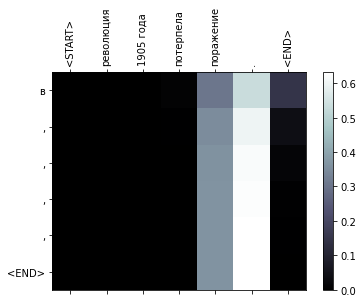

In [ ]:
output_words, attentions = predict(dataset[13])
print(output_words)
showAttention(dataset[13], output_words, attentions)